In [7]:
# Load 6 replicates


# load the SDVAE encoder and decoders 

import os
import torch
import torchvision.transforms as transforms
from PIL import Image
from diffusers import AutoencoderKL
import numpy as np
import matplotlib.pyplot as plt


# Define directory and filename
dir_sim = '/hpc/group/youlab/ks723/storage/MATLAB_SIMS/Sim_031524/Selected_v4_ALL' 
dir_exp='/hpc/group/youlab/ks723/storage/Exp_images/Final_folder_uniform_fixedseed'
# filename = 'Fixed_19_4.TIF'
# image_path = os.path.join(dir_sim, filename)

# Initialize the Stable Diffusion VAE model
device = "cuda" if torch.cuda.is_available() else "cpu"
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)

# Define transform for resizing and converting to tensor
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Define encoding and decoding functions based on your workflow
def encode_img(input_img):
    """
    Encodes the input image tensor into latent space.
    """
    if len(input_img.shape) < 4:
        input_img = input_img.unsqueeze(0)
    with torch.no_grad():
        latent = vae.encode(input_img * 2 - 1)  # Scale to [-1, 1] range
    return 0.18215 * latent.latent_dist.sample()

def decode_img(latents):
    """
    Decodes the latent representation back to image space.
    """
    latents = (1 / 0.18215) * latents  # Undo the scaling applied during encoding
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)  # Scale back to [0, 1] for image
    return image



# preprocessing

# Define the cropping offsets
top_crop_o = 30
bottom_crop_o = 30
left_crop_o = 31
right_crop_o = 30

# Step 1: Load and preprocess the image
def load_and_preprocess_image(image_path, top_crop, bottom_crop, left_crop, right_crop, target_size=(256, 256)):
    """
    Load an image, crop it according to the specified dimensions, and resize to a target size.
    """
    # Load the image and convert to RGB
    original_image = Image.open(image_path).convert('RGB')

    # Convert PIL Image to NumPy array for cropping
    image_np = np.array(original_image)

    # Perform cropping
    cropped_image_np = image_np[
        top_crop : image_np.shape[0] - bottom_crop,
        left_crop : image_np.shape[1] - right_crop
    ]

    # Convert the cropped NumPy array back to a PIL image
    cropped_image = Image.fromarray(cropped_image_np)

    # Resize the cropped image to the target size
    resized_image = cropped_image.resize(target_size)

    return resized_image

# processed_image = load_and_preprocess_image(image_path, top_crop_o, bottom_crop_o, left_crop_o, right_crop_o)




/hpc/group/youlab/ks723/miniconda3/envs/test_pytorch_ipy/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


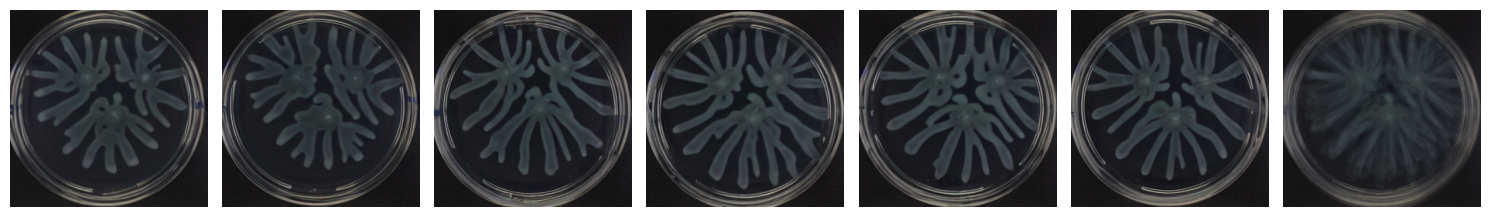

In [8]:
# Compute the average of the image and display

import re
from glob import glob

# Use regex to find all replicate files matching the pattern
def get_replicate_paths(base_dir, base_name):
    """
    Finds all files matching the pattern for replicates of a given base name.
    Example base_name: "Fixed_19" (without the replicate number and extension)
    """
    pattern = os.path.join(base_dir, f"{base_name}_*.TIF")
    replicate_files = sorted(glob(pattern))
    return replicate_files

# Define the base name (e.g., "Fixed_19")
base_name = "Fixed_19"

# Get all replicate file paths
replicate_paths = get_replicate_paths(dir_exp, base_name)

# Iterate over all replicate files for processing
for image_path in replicate_paths:
  import matplotlib.pyplot as plt
import numpy as np

# Iterate over all replicate files and store processed images
processed_images = []
for image_path in replicate_paths:
    processed_image = load_and_preprocess_image(image_path, top_crop_o, bottom_crop_o, left_crop_o, right_crop_o)
    image_tensor = transform(processed_image).unsqueeze(0).to(device)  # Apply transform and add batch dimension
    latent = encode_img(image_tensor)  # Encode the image
    decoded_image = decode_img(latent)  # Decode back to image space
    processed_images.append(decoded_image[0].cpu().numpy())  # Collect decoded image as numpy array

# Stack images and calculate the average
processed_images = np.stack(processed_images, axis=0)  # Shape: (num_images, channels, height, width)
average_image = np.mean(processed_images, axis=0)  # Average across the first dimension

# Plot all images side by side
fig, axes = plt.subplots(1, len(processed_images) + 1, figsize=(15, 5))

for i, img in enumerate(processed_images):
    axes[i].imshow(np.transpose(img, (1, 2, 0)))  # Transpose to (height, width, channels) for plotting
    axes[i].axis("off")  # Turn off axes

# Plot the average image
axes[-1].imshow(np.transpose(average_image, (1, 2, 0)))
axes[-1].axis("off")  # Turn off axes

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()





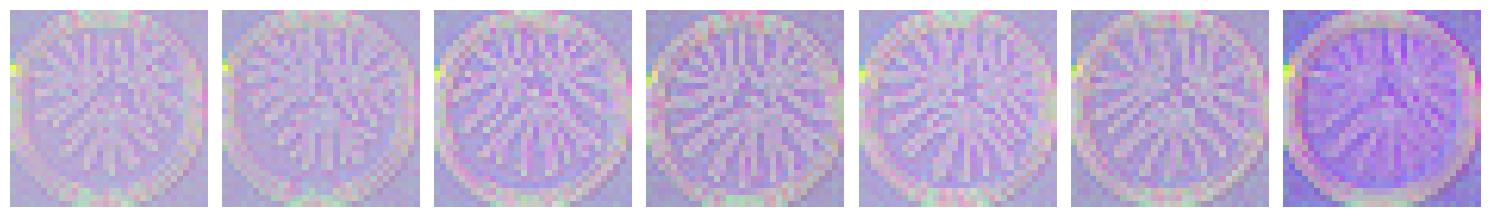

In [ ]:
# compute the latents of the six images

# Initialize a list to store latents for all replicates
all_latents = []

# Iterate over all replicate files to calculate latents
for image_path in replicate_paths:
    # Preprocess the image
    processed_image = load_and_preprocess_image(image_path, top_crop_o, bottom_crop_o, left_crop_o, right_crop_o)
    
    # Transform the image to a tensor
    image_tensor = transform(processed_image).unsqueeze(0).to(device)

    # Encode the image to get its latent representation
    latent = encode_img(image_tensor)  # Shape: [1, 4, H, W]

    # Add the latent to the list
    all_latents.append(latent.cpu().numpy())  # Move to CPU and convert to NumPy

# Stack all latents and calculate the average
all_latents = np.stack(all_latents, axis=0)  # Shape: [num_replicates, 4, H, W]
average_latent = np.mean(all_latents, axis=0)  # Average across replicates, Shape: [4, H, W]

# Display all replicates' latents and the average
fig, axes = plt.subplots(1, len(replicate_paths) + 1, figsize=(15, 5))

# Plot each replicate's 4-channel latent
for i, latent in enumerate(all_latents):
    # Normalize latent for visualization
    latent = latent - latent.min()
    latent = latent / latent.max()

    # Permute dimensions for visualization
    latent_image = latent.squeeze(0).transpose(1, 2, 0)  # Shape: [H, W, 4]

    # Convert to PIL Image for display
    latent_pil = Image.fromarray((latent_image * 255).astype('uint8'))
    axes[i].imshow(latent_pil)
    axes[i].axis('off')

# 1. Save the unscaled average latent
average_latent_unscaled = average_latent.copy()

# # (Optional) Normalize the average latent for visualization purposes
# # This does NOT affect average_latent_unscaled and is only for display
# average_latent_visual = average_latent - average_latent.min()
# average_latent_visual = average_latent_visual / average_latent_visual.max()


# Normalize the average latent for visualization
average_latent = average_latent - average_latent.min()
average_latent = average_latent / average_latent.max()

# Permute dimensions for visualization
average_latent_image = average_latent.squeeze(0).transpose(1, 2, 0)  # Shape: [H, W, 4]

# Convert the average latent to PIL Image for display
average_latent_pil = Image.fromarray((average_latent_image * 255).astype('uint8'))
axes[-1].imshow(average_latent_pil)
axes[-1].axis('off')

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()




average_latent_unscaled shape: (1, 4, 32, 32)


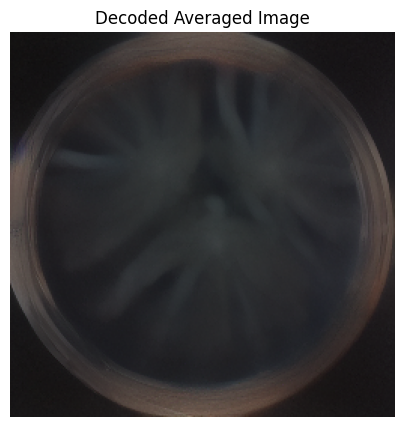

In [23]:
# Assume average_latent_unscaled is already computed and is a NumPy array

import torch
import numpy as np
import matplotlib.pyplot as plt

# Check the shape of average_latent_unscaled
print("average_latent_unscaled shape:", average_latent_unscaled.shape)

# Convert the unscaled average latent to a tensor without adding extra dimensions
if average_latent_unscaled.ndim == 3:
    # Shape is [4, 32, 32], add batch dimension
    average_latent_tensor = torch.from_numpy(average_latent_unscaled).float().unsqueeze(0).to(device)  # [1, 4, 32, 32]
elif average_latent_unscaled.ndim == 4 and average_latent_unscaled.shape[0] == 1:
    # Shape is already [1, 4, 32, 32], no need to unsqueeze
    average_latent_tensor = torch.from_numpy(average_latent_unscaled).float().to(device)  # [1, 4, 32, 32]
else:
    raise ValueError(f"Unexpected shape for average_latent_unscaled: {average_latent_unscaled.shape}")

# Decode the averaged latent
decoded_average_image = decode_img(average_latent_tensor)  # Expected shape: [1, 3, 256, 256]

# Prepare the decoded image for display
decoded_average_image = decoded_average_image.squeeze(0).cpu().numpy()  # [3, 256, 256]
decoded_average_image = np.transpose(decoded_average_image, (1, 2, 0))  # [256, 256, 3]
decoded_average_image = (decoded_average_image * 255).astype('uint8')  # [256, 256, 3]

# Display the decoded averaged image
plt.figure(figsize=(5, 5))
plt.imshow(decoded_average_image)
plt.axis('off')
plt.title("Decoded Averaged Image")
plt.show()


In [26]:
def load_and_preprocess_image_v2(image_path, top_crop, bottom_crop, left_crop, right_crop, img_length, img_width):
    """
    Load an image using PIL, apply preprocessing steps including circle detection, masking,
    contrast adjustment, thresholding, cropping, and resizing.

    Parameters:
    - image_path (str): Path to the image file.
    - top_crop (int): Number of pixels to crop from the top.
    - bottom_crop (int): Number of pixels to crop from the bottom.
    - left_crop (int): Number of pixels to crop from the left.
    - right_crop (int): Number of pixels to crop from the right.
    - img_length (int): Desired width after resizing.
    - img_width (int): Desired height after resizing.

    Returns:
    - PIL.Image or None: The preprocessed and resized image as a PIL Image,
                         or None if preprocessing fails.
    """
    try:
        # 1. Load image using PIL
        pil_image = Image.open(image_path).convert('RGB')
        img_array = np.array(pil_image)

        # Convert RGB to BGR for OpenCV
        img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)

        # 2. Convert to grayscale for edge and circle detection
        img_gray = cv2.cvtColor(img_array, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(img_gray, 100, 200)

        # 3. Find circles in the image using HoughCircles
        circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1, minDist=20,
                                   param1=50, param2=30, minRadius=20, maxRadius=600)

        if circles is not None:
            circles = np.round(circles[0, :]).astype("int")
            # Select the first detected circle (modify as needed)
            x_center, y_center, radius = circles[0]
            new_radius = radius - 82
            if new_radius <= 0:
                print(f"Adjusted radius is non-positive for image {image_path}. Skipping.")
                return None

            # 4. Create a circular mask
            mask = np.zeros((img_array.shape[0], img_array.shape[1]), dtype=np.uint8)
            cv2.circle(mask, (x_center, y_center), new_radius, 255, -1)

            # 5. Apply the mask to the original image
            img_masked = cv2.bitwise_and(img_array, img_array, mask=mask)

            # 6. Adjust contrast and brightness
            alpha = 1.5  # Contrast control
            beta = 50    # Brightness control
            adjusted_image = cv2.convertScaleAbs(img_masked, alpha=alpha, beta=beta)

            # 7. Convert to grayscale and apply thresholding
            img_gray_adj = cv2.cvtColor(adjusted_image, cv2.COLOR_BGR2GRAY)
            blur = cv2.GaussianBlur(img_gray_adj, (5, 5), 0)
            _, img_thresh = cv2.threshold(blur, 110, 255, cv2.THRESH_BINARY)

            # 8. Calculate new dimensions after cropping
            new_height = img_thresh.shape[0] - (top_crop + bottom_crop)
            new_width = img_thresh.shape[1] - (left_crop + right_crop)

            if new_height <= 0 or new_width <= 0:
                print(f"Invalid cropping dimensions for image {image_path}. Skipping.")
                return None

            # 9. Perform cropping
            img_cropped = img_thresh[top_crop:top_crop + new_height, left_crop:left_crop + new_width]

            # 10. Resize the image
            img_resized = cv2.resize(img_cropped, (img_length, img_width))

        else:
            print(f"No circles detected in image {image_path}. Skipping.")
            return None

        # 11. Convert the processed image back to RGB (from grayscale)
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)

        # 12. Convert to PIL Image for compatibility with torchvision transforms
        pil_processed_image = Image.fromarray(img_rgb)

        return pil_processed_image

    except Exception as e:
        print(f"An error occurred while processing image {image_path}: {e}")
        return None
    


    

In [ ]:
# show all 6 images in a row and display the average of the latents

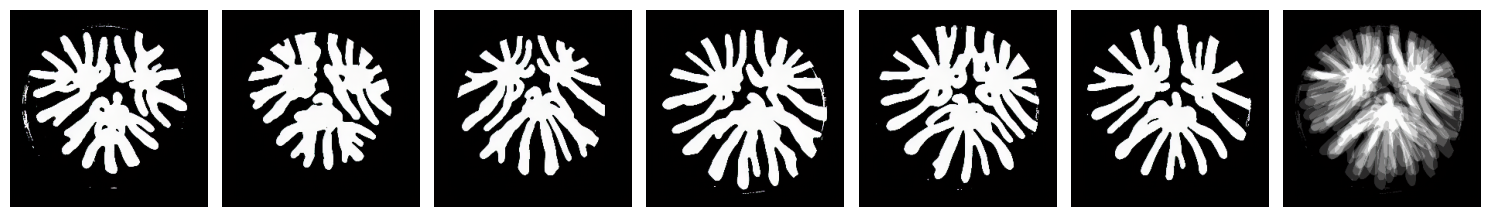

In [30]:
# Compute the average of the image and display

import re
from glob import glob
import cv2

# Use regex to find all replicate files matching the pattern
def get_replicate_paths(base_dir, base_name):
    """
    Finds all files matching the pattern for replicates of a given base name.
    Example base_name: "Fixed_19" (without the replicate number and extension)
    """
    pattern = os.path.join(base_dir, f"{base_name}_*.TIF")
    replicate_files = sorted(glob(pattern))
    return replicate_files

# Define the base name (e.g., "Fixed_19")
base_name = "Fixed_19"

# Get all replicate file paths
replicate_paths = get_replicate_paths(dir_exp, base_name)

# Iterate over all replicate files for processing
for image_path in replicate_paths:
  import matplotlib.pyplot as plt
import numpy as np

# Iterate over all replicate files and store processed images
processed_images = []
for image_path in replicate_paths:
    processed_image = load_and_preprocess_image_v2(image_path, top_crop_o, bottom_crop_o, left_crop_o, right_crop_o,256,256)
    image_tensor = transform(processed_image).unsqueeze(0).to(device)  # Apply transform and add batch dimension
    latent = encode_img(image_tensor)  # Encode the image
    decoded_image = decode_img(latent)  # Decode back to image space
    processed_images.append(decoded_image[0].cpu().numpy())  # Collect decoded image as numpy array

# Stack images and calculate the average
processed_images = np.stack(processed_images, axis=0)  # Shape: (num_images, channels, height, width)
average_image = np.mean(processed_images, axis=0)  # Average across the first dimension

# Plot all images side by side
fig, axes = plt.subplots(1, len(processed_images) + 1, figsize=(15, 5))

for i, img in enumerate(processed_images):
    axes[i].imshow(np.transpose(img, (1, 2, 0)))  # Transpose to (height, width, channels) for plotting
    axes[i].axis("off")  # Turn off axes

# Plot the average image
axes[-1].imshow(np.transpose(average_image, (1, 2, 0)))
axes[-1].axis("off")  # Turn off axes

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()





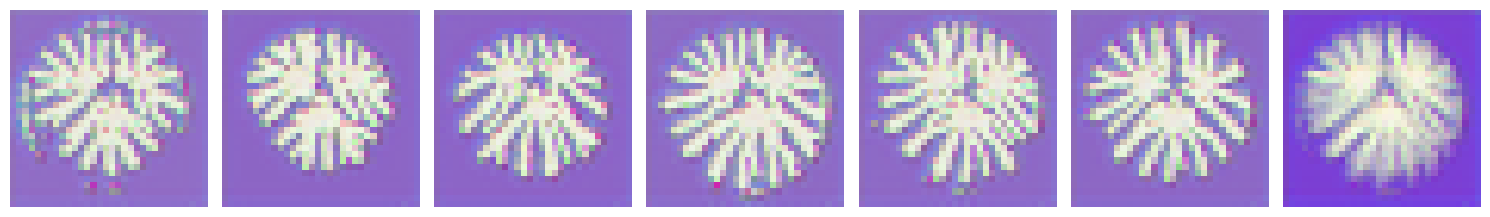

In [32]:
# compute the latents of the six image

# Initialize a list to store latents for all replicates
all_latents = []

# Iterate over all replicate files to calculate latents
for image_path in replicate_paths:
    # Preprocess the image
    processed_image = load_and_preprocess_image_v2(image_path, top_crop_o, bottom_crop_o, left_crop_o, right_crop_o,256,256)
    
    # Transform the image to a tensor
    image_tensor = transform(processed_image).unsqueeze(0).to(device)

    # Encode the image to get its latent representation
    latent = encode_img(image_tensor)  # Shape: [1, 4, H, W]

    # Add the latent to the list
    all_latents.append(latent.cpu().numpy())  # Move to CPU and convert to NumPy

# Stack all latents and calculate the average
all_latents = np.stack(all_latents, axis=0)  # Shape: [num_replicates, 4, H, W]
average_latent = np.mean(all_latents, axis=0)  # Average across replicates, Shape: [4, H, W]

# Display all replicates' latents and the average
fig, axes = plt.subplots(1, len(replicate_paths) + 1, figsize=(15, 5))

# Plot each replicate's 4-channel latent
for i, latent in enumerate(all_latents):
    # Normalize latent for visualization
    latent = latent - latent.min()
    latent = latent / latent.max()

    # Permute dimensions for visualization
    latent_image = latent.squeeze(0).transpose(1, 2, 0)  # Shape: [H, W, 4]

    # Convert to PIL Image for display
    latent_pil = Image.fromarray((latent_image * 255).astype('uint8'))
    axes[i].imshow(latent_pil)
    axes[i].axis('off')

# 1. Save the unscaled average latent
average_latent_unscaled = average_latent.copy()

# # (Optional) Normalize the average latent for visualization purposes
# # This does NOT affect average_latent_unscaled and is only for display
# average_latent_visual = average_latent - average_latent.min()
# average_latent_visual = average_latent_visual / average_latent_visual.max()


# Normalize the average latent for visualization
average_latent = average_latent - average_latent.min()
average_latent = average_latent / average_latent.max()

# Permute dimensions for visualization
average_latent_image = average_latent.squeeze(0).transpose(1, 2, 0)  # Shape: [H, W, 4]

# Convert the average latent to PIL Image for display
average_latent_pil = Image.fromarray((average_latent_image * 255).astype('uint8'))
axes[-1].imshow(average_latent_pil)
axes[-1].axis('off')

# Adjust spacing and show the plot
plt.tight_layout()
plt.show()




average_latent_unscaled shape: (1, 4, 32, 32)


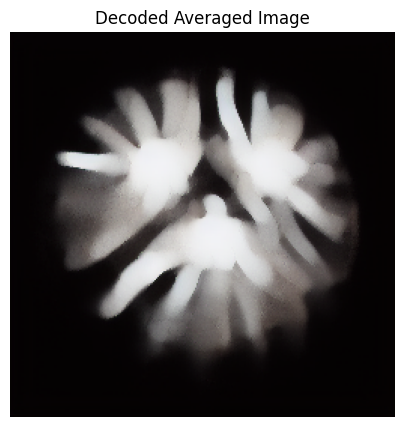

In [33]:
# Assume average_latent_unscaled is already computed and is a NumPy array

import torch
import numpy as np
import matplotlib.pyplot as plt

# Check the shape of average_latent_unscaled
print("average_latent_unscaled shape:", average_latent_unscaled.shape)

# Convert the unscaled average latent to a tensor without adding extra dimensions
if average_latent_unscaled.ndim == 3:
    # Shape is [4, 32, 32], add batch dimension
    average_latent_tensor = torch.from_numpy(average_latent_unscaled).float().unsqueeze(0).to(device)  # [1, 4, 32, 32]
elif average_latent_unscaled.ndim == 4 and average_latent_unscaled.shape[0] == 1:
    # Shape is already [1, 4, 32, 32], no need to unsqueeze
    average_latent_tensor = torch.from_numpy(average_latent_unscaled).float().to(device)  # [1, 4, 32, 32]
else:
    raise ValueError(f"Unexpected shape for average_latent_unscaled: {average_latent_unscaled.shape}")

# Decode the averaged latent
decoded_average_image = decode_img(average_latent_tensor)  # Expected shape: [1, 3, 256, 256]

# Prepare the decoded image for display
decoded_average_image = decoded_average_image.squeeze(0).cpu().numpy()  # [3, 256, 256]
decoded_average_image = np.transpose(decoded_average_image, (1, 2, 0))  # [256, 256, 3]
decoded_average_image = (decoded_average_image * 255).astype('uint8')  # [256, 256, 3]

# Display the decoded averaged image
plt.figure(figsize=(5, 5))
plt.imshow(decoded_average_image)
plt.axis('off')
plt.title("Decoded Averaged Image")
plt.show()
